In [ ]:
#### Field Plots #####
import os
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import math
from scipy.stats import norm
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import sys

sys.setrecursionlimit(100000)

###########################################################################################################################
def make_netcdffile_fromcross(time_start, time_end, time_gap, x_spacing, variable_name, path, output_name, del_files): 
    float_type = 'f4'
    time_ind_total = int((time_end-time_start)/time_gap) + 1
    time = np.linspace(time_start,time_end,time_ind_total)
    filename = path+variable_name + str(format(int(time[0]),'07d'))
    fid=open(filename,'rb')
    x_length = int(np.sqrt(len(np.fromfile(fid))))
    x=np.linspace(x_spacing,x_length*x_spacing,x_length)
    y=np.linspace(x_spacing,x_length*x_spacing,x_length)
    fid.close()
    if os.path.exists(path+output_name):
        os.remove(path+output_name)
    nc_file = nc.Dataset(path+output_name, mode="w", datamodel="NETCDF4", clobber=False)
    nc_file.createDimension("x", x_length)
    nc_file.createDimension("y", x_length)
    nc_file.createDimension("t", time_ind_total)
    nc_x = nc_file.createVariable("x", float_type, ("x"))
    nc_y = nc_file.createVariable("y", float_type, ("y"))
    nc_t = nc_file.createVariable("t", float_type, ("t"))
    var_name = variable_name.split('.')[0]
    locals()[var_name] = np.zeros((x_length,x_length,time_ind_total))
    locals()['nc_'+var_name] = nc_file.createVariable(var_name, float_type, ("x","y","t"))                    
    for i in range(0,time_ind_total):
        filename = path+variable_name+str(format(int(time[i]),'07d'))
        fid=open(filename,'rb')
        var = np.fromfile(fid)
        locals()[var_name][:,:,i]=np.reshape(var,[x_length,x_length])
        fid.close()
    locals()['nc_'+var_name][:] = locals()[var_name][:]




    nc_x [:] = x[:]
    nc_y [:] = y[:]
    nc_t [:] = time[:]
    nc_file.close()
    if del_files:
        #files = ["u", "v", "w", "thl", "time", "qr", "ql", "couv", "grid", "nr","qt","therm","bc"]
        files = [variable_name]
        for file in os.listdir(path):
            for i in range(0,len(files)):
                if file.find(files[i])!=-1: 
                    os.remove(path+file)
                #rm u* v* w* thl* time* qr* ql* couv* grid* nr* qt* therm* 
##########################################################################################
class cell:
    def __init__(self, id):
        self.id = id
        self.value = [[]]
        self.location = [[],[]]
        self.nelements = 0
        self.nelements_local = 0

    def add_elements(self, i, j, var_values):
        self.location[0].append(i)
        self.location[1].append(j)
        self.value[0].append(var_values)
        self.nelements = self.nelements + 1
        self.nelements_local = self.nelements_local + 1
    def __del__(self):
        return
##########################################################################################
def find_boolean(variable, threshold_criteria): #variable is f(i, j, t): --> outputs boolean -1 (unsatisfied) 0 (satisfied) 
    boolean = np.zeros(( len(variable[:,0]), len(variable[0,:])))
    boolean = -1
    boolean = np.where(variable[:,:]>threshold_criteria,0,-1)
    return boolean;
########################################################################################
def identify_elements_in_cell(i,j,new_cell):  #input the ijk at which boolean is satisfied along with boolean and new cell created 

    global booli;
    new_cell.add_elements(i,j,cell_variable[i,j])
    booli[i,j] = -1

    ii=i-1; jj=j; #look west
    if ii<0:
       ii = nx-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i+1; jj=j;  #look east
    if ii>nx-1:
       ii = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j+1;  #look north
    if jj>ny-1:
        jj = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j-1;  #look south
    if jj<0:
       jj = ny-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell) 
#################################################################################################
def create_new_cell(variable,bool):                                # input the boolean and the variable, output is the cells tracked (i,j,t) based on boolean 
    cell_number = 0;
    global booli,cell_variable,nx,ny;
    nx = len(variable[:,0])
    ny = len(variable[0,:])
    booli=bool;cell_variable = variable;
    variable_cells = []
    for j in range(0,ny):
        for i in range(0,nx):
            if booli[i,j]==0: 
                new_cell=cell(cell_number) 
                identify_elements_in_cell(i,j,new_cell)
                if new_cell.nelements>=nminelems:
                    variable_cells.append(new_cell)
                    variable_cells[cell_number].id = cell_number
                    cell_number = cell_number + 1
                else:
                    del new_cell;
    return variable_cells, cell_number;
#################################################################################################
def run_tracking(tracked_variable,param_threshold):
    global nx,ny;
    nx = len(tracked_variable[:,0]); ny = len(tracked_variable[0,:]); 
    bool = find_boolean(tracked_variable,param_threshold)
    [cells,cell_number] = create_new_cell(tracked_variable,bool);
    return cells,cell_number;
####################################################################################################
def find_cell_centers(cells,ncells):
    centers=np.zeros((ncells,2))
    for i in range(0,ncells):
        centers[i,0]=np.mean(cells[i].location[0])
        centers[i,1]=np.mean(cells[i].location[1])
    return centers;
####################################################################################################
def find_nearest_neighbor(centers,nx,ny):
    distance=np.zeros(len(centers[:,0]))
    nn_distance=np.zeros(len(centers[:,0]))
    for i in range(len(centers[:,0])):
        for j in range(len(centers[:,0])):
            if i==j:
                distance[j]=100;
            else:
                xdist=min(abs(centers[i,0]+nx-centers[j,0]),abs(centers[i,0]-nx-centers[j,0]),abs(centers[i,0]-centers[j,0]))
                ydist=min(abs(centers[i,1]+ny-centers[j,1]),abs(centers[i,1]-ny-centers[j,1]),abs(centers[i,1]-centers[j,1]))
                distance[j]=math.sqrt(xdist**2+ydist**2)
        nn_distance[i]=min(distance)
    return nn_distance;
####################################################################################################
def retrieve_variable(variable_name,netcdf_path): #open corresponding netcdf file and read data
    all_data=xr.open_dataset(netcdf_path)
    var=all_data[variable_name].values
    variable=var
    x=all_data['x'].values
    y=all_data['y'].values
    t=all_data['t'].values
    return variable, x, y, t;    
##########################################################################################
#[w_cross,x,y,t]=retrieve_variable(variable_name='w',netcdf_path='/fs/ess/PFS0220/eurec4a/case_1060lagtraj_feb2_withw/w_cross.nc')
def get_iorg(variable,param_threshold,start_ind,stop_ind):
    i_org=np.zeros(len(variable[0,0,start_ind:stop_ind+1]))
    for i in range(0,stop_ind-start_ind+1):
        [updraft,ncells]=run_tracking(tracked_variable=variable[:,:,start_ind+i],param_threshold=param_threshold)
        if ncells<2:
            i_org[i]=0;
        else:
            centers=find_cell_centers(updraft,ncells)
            nn_distance=find_nearest_neighbor(centers,nx,ny)
            centers=centers.astype(int)
            nn_sorted = np.sort(nn_distance*delx/1000);nn_sorted=nn_sorted/max(nn_sorted)
            p = 1. * np.arange(len(nn_distance)) / (len(nn_distance) - 1)
            p_ran=1-np.exp(-1*(math.pi)*nn_sorted*nn_sorted)
            i_org[i]=np.trapz(p,x=p_ran)
        if i==0 and ncells>2:
            pl.figure()
            pl.contour(x/1000,y/1000,variable[:,:,start_ind+i]>1)
            pl.title('w > 1 ms$^-1$ at z = 800 m')
            pl.xlabel('X (km)')
            pl.ylabel('Y (km)')
            pl.show()
            
            pl.figure()
            center_arr=np.zeros((nx,ny))
            center_arr[(centers[:,0]),(centers[:,1])]=1;
            pl.contour(x/1000,y/1000,center_arr)
            pl.xlabel('x')
            pl.ylabel('y')
            pl.title('Centroids of Updrafts')

            pl.figure()
            distance_arr=np.zeros((nx,ny))
            distance_arr[(centers[:,0]),(centers[:,1])]=nn_distance;
            pl.contour(x/1000,y/1000,center_arr)
            pl.xlabel('x')
            pl.ylabel('y')
            pl.title('Centroids of Updrafts')

            pl.figure()
            pl.plot(nn_sorted,p,nn_sorted,p_ran)
            pl.xlabel('x (NN Distance)')
            pl.ylabel('p=F(x)')

            pl.figure()
            pl.plot(p_ran,p,p_ran,p_ran,'b--')
            pl.xlabel('Random CDF')
            pl.ylabel('NNCDF')            

        print(i)
    return i_org;
#########################################################################################
def get_maxelems(variable,param_threshold,start_ind,stop_ind):
    maxelems=np.zeros(len(variable[0,0,start_ind:stop_ind+1]))
    maxcell_value=np.zeros(len(variable[0,0,start_ind:stop_ind+1]))
    for i in range(0,stop_ind-start_ind+1):
        [updraft,ncells]=run_tracking(tracked_variable=variable[:,:,start_ind+i],param_threshold=param_threshold)
        nelems=np.zeros((ncells))
        for j in range(0,ncells):
            nelems[j]=updraft[j].nelements
        maxelems[i]=max(nelems,default=0)
        if maxelems[i]>0:
            ind=np.nonzero(nelems==max(nelems))[0][0]
            maxcell_value[i]=np.sum(updraft[ind].value[0][:])
        
        if i%10==0:
            print(i)
    return maxelems,maxcell_value;
######################################################################################################################
delx=200
nc_path='/fs/ess/PFS0220/eurec4a/case_1060lagtraj_feb2_withw/'
#make_netcdffile_fromcross(time_start=0,time_end=3456,time_gap=9,x_spacing=delx,variable_name='couvreux.xy.00045.',path=nc_path,output_name='couvreux_cross2.nc',del_files=True)

#[w_cross,x,y,t]=retrieve_variable(variable_name='w',netcdf_path=nc_path+'w_cross.nc')
#nx=len(x);ny=len(y); start_ind=np.nonzero(t==180)[0][0]; stop_ind=np.nonzero(t==1395)[0][0]
#nminelems=10;
#i_org1=get_iorg(variable=w_cross,param_threshold=1,start_ind=start_ind,stop_ind=stop_ind)
#t1=t[start_ind:stop_ind+1]

[w_cross1,x,y,t]=retrieve_variable(variable_name='w',netcdf_path=nc_path+'w_cross1.nc')
nx=len(x);ny=len(y); start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
nminelems=2;
i_org1=get_iorg(variable=w_cross1,param_threshold=1,start_ind=start_ind,stop_ind=stop_ind)
tt=t[start_ind:stop_ind+1]

[w_cross2,x,y,t]=retrieve_variable(variable_name='w',netcdf_path=nc_path+'w_cross2.nc')
nx=len(x);ny=len(y); start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
nminelems=2; #t3=t[start_ind:stop_ind+1]
i_org2=get_iorg(variable=w_cross2,param_threshold=1,start_ind=start_ind,stop_ind=stop_ind)

[couv_cross1,x,y,t]=retrieve_variable(variable_name='couvreux',netcdf_path=nc_path+'couvreux_cross1.nc')
start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
i_org3=get_iorg(variable=couv_cross1,param_threshold=1e-5,start_ind=start_ind,stop_ind=stop_ind)
#[max_ql,ql_cell]=get_maxelems(variable=qlpath,param_threshold=0.01,start_ind=start_ind,stop_ind=stop_ind)

[couv_cross2,x,y,t]=retrieve_variable(variable_name='couvreux',netcdf_path=nc_path+'couvreux_cross2.nc')
start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
i_org4=get_iorg(variable=couv_cross2,param_threshold=1e-5,start_ind=start_ind,stop_ind=stop_ind)

#[qrpath,x,y,t]=retrieve_variable(variable_name='qrpath',netcdf_path=nc_path+'qrpath.nc')
#[max_qr,qr_cell]=get_maxelems(variable=qrpath,param_threshold=1e-4,start_ind=start_ind,stop_ind=stop_ind)

#[qrfluxbot,x,y,t]=retrieve_variable(variable_name='qrfluxbot',netcdf_path=nc_path+'qrfluxbot.nc')
#i_org=np.concatenate((i_org1,i_org2,i_org3))
#t_all=np.concatenate((t1,t2,t3))

#fig,ax=pl.subplots()
#pl.plot(t_all*100/3600,i_org)
#ax.plot(t3*100/3600,max_ql,'b-',t3*100/3600,max_qr,'r--')
#ax.set_xlabel('Time (in Hours)')
#ax.set_ylabel('Max_elelms')
#pl.yscale('log')
#ax2=ax.twinx()
#ax2.plot(t3*100/3600,i_org3,'g.-')
#ax2.set_ylabel('i_org')

#fig,ax=pl.subplots()
#ax.plot(t3*100/3600,ql_cell,'b-')
#ax.set_xlabel('Time (in Hours)')
#ax.set_ylabel('ql sum over Max Cell')
#pl.yscale('log')
#ax2=ax.twinx()
#ax2.plot(t3*100/3600,qr_cell,'r--')
#ax2.set_ylabel('qr sum over Max Cell')
#pl.yscale('log')
#hrs=80.25
#pl.figure()
#pl.contour(x,y,qlpath[:,:,int(hrs/100*3600)])

fig,ax=pl.subplots()
ax.plot(tt*100/3600,i_org1,'b-',tt*100/3600,i_org2,'r--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('iorg')

fig,ax=pl.subplots()
ax.plot(tt*100/3600,i_org3,'b-',tt*100/3600,i_org4,'r--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('iorg')

In [ ]:
from scipy.signal import savgol_filter
i_org_hat=savgol_filter(i_org3,51,3)
fig,ax=pl.subplots()
ax.plot(tt*100/3600,i_org_hat,'b-',tt*100/3600,i_org4,'r--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('iorg')
hrs=83
ind=np.nonzero(t*100/3600==hrs)[0][0]
levs=np.concatenate((np.linspace(0,0.0001,20),np.linspace(0.00011,1,1)))
pl.figure()
#pl.contourf(x/1000,y/1000,qlpath[:,:,int(ind)],levels=levs,cmap=cm.gray)
pl.contour(x/1000,y/1000,couv_cross1[:,:,int(ind)]>1e-5)
pl.colorbar()

pl.figure()
pl.contour(x/1000,y/1000,w_cross1[:,:,int(ind)]>1)
pl.colorbar()

pl.figure()
pl.contour(x/1000,y/1000,w_cross2[:,:,int(ind)]>1)
pl.colorbar()

pl.figure()
pl.contour(x/1000,y/1000,qrfluxbot[:,:,int(ind)])
pl.colorbar()

i_org_hat=savgol_filter(i_org3,51,4)
qr_cell_hat=savgol_filter(qr_cell,51,3)
fig,ax=pl.subplots()
#pl.plot(t_all*100/3600,i_org)
ax.plot(t3*100/3600,max_ql,'b-',t3*100/3600,max_qr,'r--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('Max_elelms')
pl.yscale('log')
ax2=ax.twinx()
ax2.plot(t3*100/3600,i_org3,'g-.')
ax2.set_ylabel('i_org')

fig,ax=pl.subplots()
ax.plot(t3*100/3600,i_org_hat,'b-',t3*100/3600,i_org3,'b--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('i_org')
#pl.yscale('log')
ax2=ax.twinx()
ax2.plot(t3*100/3600,qr_cell,'r--')
ax2.set_ylabel('qr sum over Max Cell')
pl.yscale('log')

<class 'netCDF4._netCDF4.Group'>
group /radiation:
    dimensions(sizes): 
    variables(dimensions): float64 lw_flux_up(time, zh), float64 lw_flux_dn(time, zh), float64 lw_flux_up_clear(time, zh), float64 lw_flux_dn_clear(time, zh), float64 sw_flux_up(time, zh), float64 sw_flux_dn(time, zh), float64 sw_flux_dn_dir(time, zh), float64 sw_flux_up_clear(time, zh), float64 sw_flux_dn_clear(time, zh), float64 sw_flux_dn_dir_clear(time, zh), float64 lw_flux_up_ref(p_rad), float64 lw_flux_dn_ref(p_rad), float64 sw_flux_up_ref(p_rad), float64 sw_flux_dn_ref(p_rad), float64 sw_flux_dn_dir_ref(p_rad), float64 sza(time), float64 sw_flux_dn_toa(time)
    groups: 


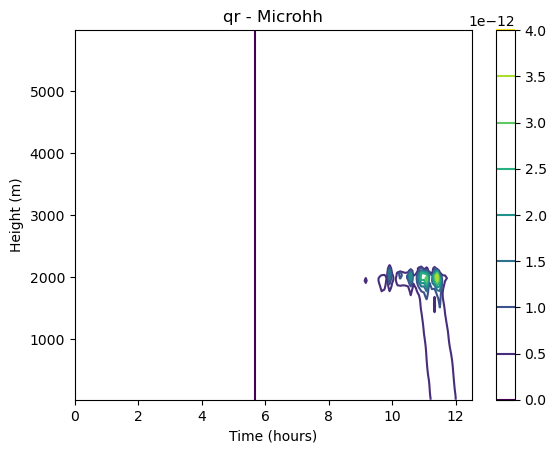

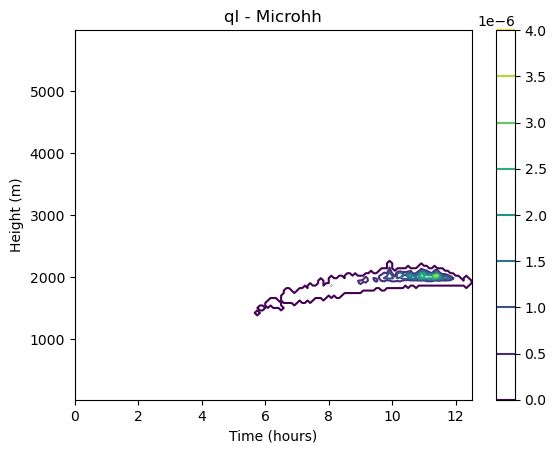

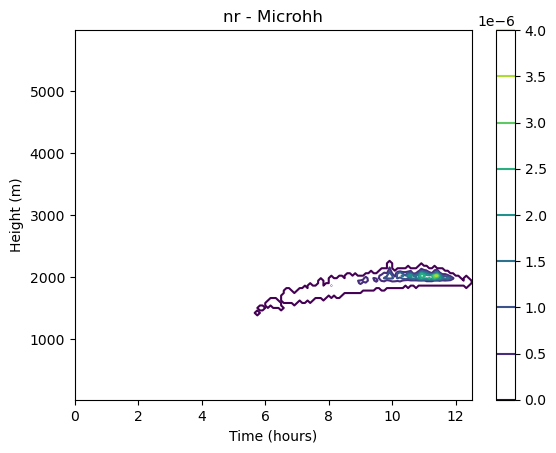

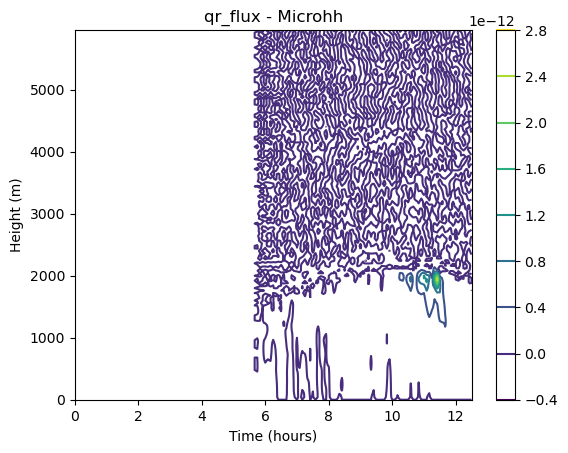

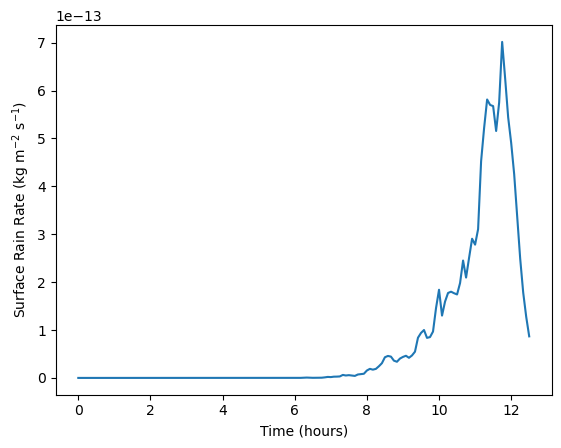

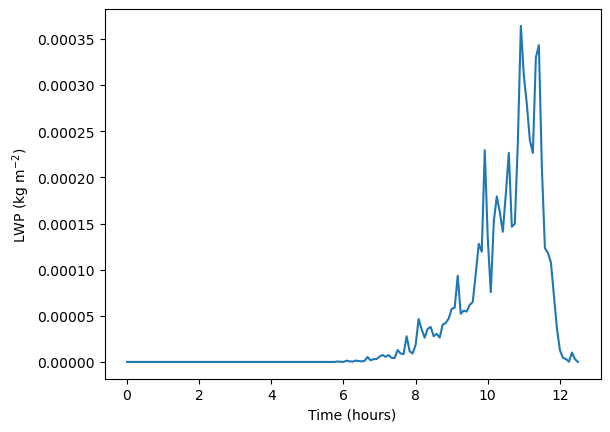

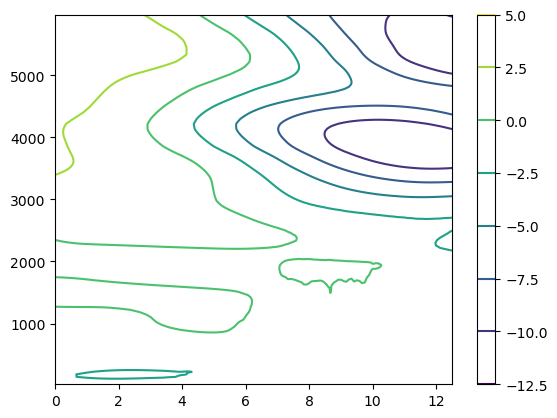

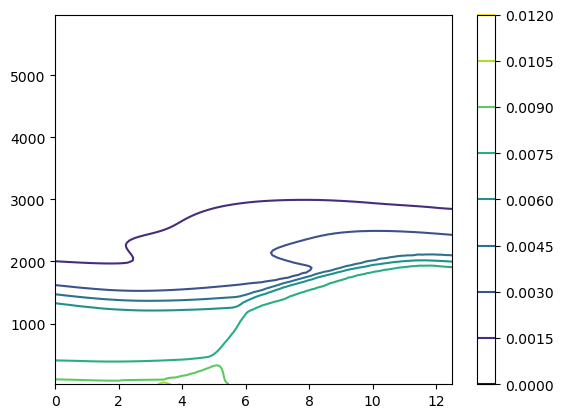

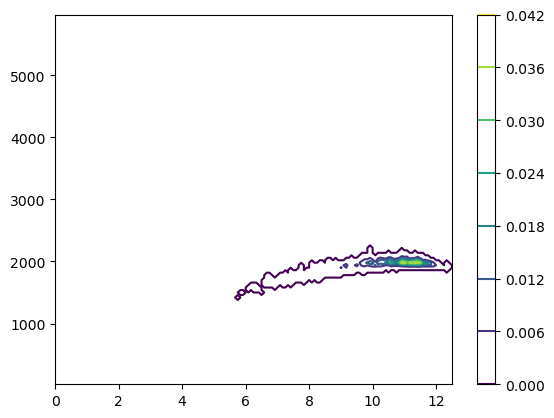

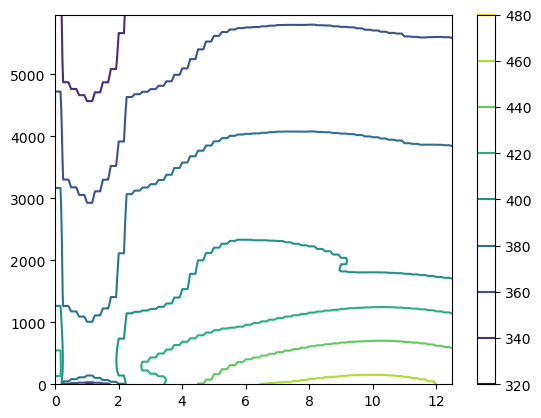

In [2]:
### Plot from 3 files ###
import numpy as np
import matplotlib.pyplot as pl
import netCDF4 as nc
import xarray as xr
from datetime import datetime


#pwd='/users/PFS0220/graghuna/microhh/microhh/cases/eurec4a/case_1060T1_feb2_100m_36hrs/'
pwd='/data/eurec4a/SEUS_09142022/'
nc_nums=1;
nc_vals = ['0000']
#nc_vals = ['0000','0576','1152','1728','2304','2880']
#nc_vals = ['0000','1152','2304']
dz=40; z_ind=int(6000/dz);
startdate=datetime(2020,1,30,00,00)


for n in range(nc_nums):
    nc_filename='eurec4a.default.000' + nc_vals[n]+'.nc';
    xrdata=xr.open_dataset(pwd+nc_filename,decode_times=False)
    xrdata_def=xr.open_dataset(pwd+nc_filename,group='default',decode_times=False);
    xrdata_thermo=xr.open_dataset(pwd+nc_filename,group='thermo',decode_times=False);
    xrdata_rad=xr.open_dataset(pwd+nc_filename,group='radiation',decode_times=False);

    z1=xrdata['z'].values
    zh1=xrdata['zh'].values
    time1=xrdata['time'].values
    qr1 = xrdata_thermo['qr'].values;
    ql1 = xrdata_thermo['ql'].values;
    qt1 = xrdata_thermo['qt'].values;
    u1 = xrdata_def['u'].values;
    ql_frac1 = xrdata_thermo['ql_frac'].values;
    rr1 = xrdata_thermo['rr'].values
    qlpath1=xrdata_thermo['ql_path']
    qr_flux1=xrdata_thermo['qr_flux'].values;
    nr1=xrdata_thermo['ql'].values;
    if n==0:
        z=z1; 
        zh=zh1; 
        time=time1;
        qr=qr1;
        ql=ql1;
        qt=qt1;
        u=u1;
        ql_frac=ql_frac1;
        rr=rr1;
        qlpath=qlpath1;
        qr_flux=qr_flux1;
        nr=nr1
    else:
        z=np.concatenate((z,z1));
        zh=np.concatenate((zh,zh1));
        time=np.concatenate((time,time1));
        qr=np.concatenate((qr,qr1));
        ql=np.concatenate((ql,ql1));
        qt=np.concatenate((qt,qt1));
        u=np.concatenate((u,u1));
        ql_frac=np.concatenate((ql_frac,ql_frac1));
        rr=np.concatenate((rr,rr1));
        qlpath=np.concatenate((qlpath,qlpath1));
        qr_flux=np.concatenate((qr_flux,qr_flux1));
        nr=np.concatenate((nr,nr1));

ds=nc.Dataset(pwd+nc_filename)
print(ds.groups['radiation'])

time=time/3600

pl.figure()
pl.contour(time,z[0:z_ind],np.transpose(qr[:,0:z_ind]))
pl.title('qr - Microhh')
pl.xlabel('Time (hours)')
pl.ylabel('Height (m)')
pl.colorbar()

pl.figure()
pl.contour(time,z[0:z_ind],np.transpose(ql[:,0:z_ind]))
pl.title('ql - Microhh')
pl.xlabel('Time (hours)')
pl.ylabel('Height (m)')
pl.colorbar()

pl.figure()
pl.contour(time,z[0:z_ind],np.transpose(nr[:,0:z_ind]))
pl.title('nr - Microhh')
pl.xlabel('Time (hours)')
pl.ylabel('Height (m)')
pl.colorbar()

pl.figure()
pl.contour(time,zh[0:z_ind],np.transpose(qr_flux[:,0:z_ind]))
pl.title('qr_flux - Microhh')
pl.xlabel('Time (hours)')
pl.ylabel('Height (m)')
pl.colorbar()

pl.figure()
pl.plot(time,rr)
pl.xlabel('Time (hours)')
pl.ylabel('Surface Rain Rate (kg m$^{-2}$ s$^{-1}$)')

pl.figure()
pl.plot(time,qlpath)
pl.xlabel('Time (hours)')
pl.ylabel('LWP (kg m$^{-2}$)')



pl.figure()
pl.contour(time,z[0:150],np.transpose(u[:,0:z_ind]))
pl.colorbar()

pl.figure()
pl.contour(time,z[0:150],np.transpose(qt[:,0:z_ind]))
pl.colorbar()

pl.figure()
pl.contour(time,z[0:150],np.transpose(ql_frac[:,0:z_ind]))
pl.colorbar()

pl.figure()
pl.contour(time,zh[0:z_ind],np.transpose(xrdata_rad['lw_flux_up'].values[:,0:z_ind]))
pl.colorbar()